In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
df=pd.read_csv("zomato.csv")
df.head()

# EDA

In [71]:
df.shape

(51148, 19)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [4]:
df.isnull().mean()*100

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [5]:
df.dtypes

url                            object
address                        object
name                           object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)                object
listed_in(city)                object
dtype: object

In [6]:
#missing values
df.drop(columns=["menu_item","dish_liked"],inplace=True)
df.dropna(how="any",subset=["approx_cost(for two people)","cuisines","rest_type","location"],inplace=True)
df["phone"].fillna(value=0,inplace=True)
df['rate'].replace(to_replace="(NEW)|(-)", value="0", regex=True, inplace=True)
df["rate"].fillna(value=50,inplace=True)
df.isnull().sum()

url                            0
address                        0
name                           0
online_order                   0
book_table                     0
rate                           0
votes                          0
phone                          0
location                       0
rest_type                      0
cuisines                       0
approx_cost(for two people)    0
reviews_list                   0
listed_in(type)                0
listed_in(city)                0
dtype: int64

In [7]:
df.shape

(51148, 15)

In [8]:
df["approx_cost(for two people)"].replace(to_replace=",", value="", regex=True, inplace=True)
df["approx_cost(for two people)"]= pd.to_numeric(df['approx_cost(for two people)'])
df["rate"].replace(to_replace="/5", value="", regex=True, inplace=True)
df["rate"]= pd.to_numeric(df['rate'])
df.dtypes

url                             object
address                         object
name                            object
online_order                    object
book_table                      object
rate                           float64
votes                            int64
phone                           object
location                        object
rest_type                       object
cuisines                        object
approx_cost(for two people)      int64
reviews_list                    object
listed_in(type)                 object
listed_in(city)                 object
dtype: object

Visualizations

<AxesSubplot:ylabel='listed_in(type)'>

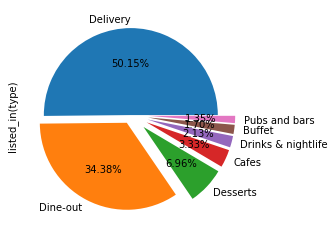

In [9]:
df["listed_in(type)"].value_counts().plot(kind="pie",autopct = '%1.2f%%', explode = [0,0.1,0.2,0.2,0.2,0.2,0.2])

<AxesSubplot:ylabel='online_order'>

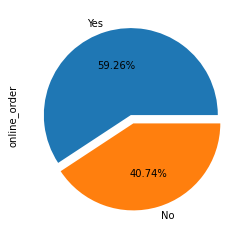

In [10]:
df["online_order"].value_counts().plot(kind="pie",autopct = '%1.2f%%', explode = [0,0.1])

<AxesSubplot:ylabel='book_table'>

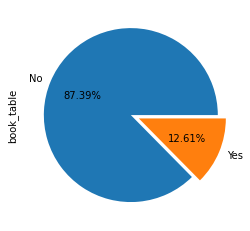

In [11]:
df["book_table"].value_counts().plot(kind="pie",autopct = '%1.2f%%', explode = [0,0.1])

In [12]:
#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer =  SentimentIntensityAnalyzer()
review_sentiment_list = []
for review in df.reviews_list:
    sentiment_list = []
    data_list = review.split('(\'Rated ')[1:]
    for data in data_list:
        text = data.split(',')[1]
        sentiment_list.append(analyzer.polarity_scores(text)['compound'])
    if len(sentiment_list):review_sentiment_list.append(mean(sentiment_list))
    else: review_sentiment_list.append(0)

In [13]:
df['review'] = review_sentiment_list

In [14]:
#Checking the variability
from sklearn.feature_selection import VarianceThreshold
v=VarianceThreshold(threshold=0.5)
v.fit(df[["rate","votes","approx_cost(for two people)","review"]])

VarianceThreshold(threshold=0.5)

In [15]:
v.get_support()

array([ True,  True,  True, False])

In [16]:
#Encoding
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df["online_order"]=lb.fit_transform(df["online_order"])
df["book_table"]=lb.fit_transform(df["book_table"])

<AxesSubplot:>

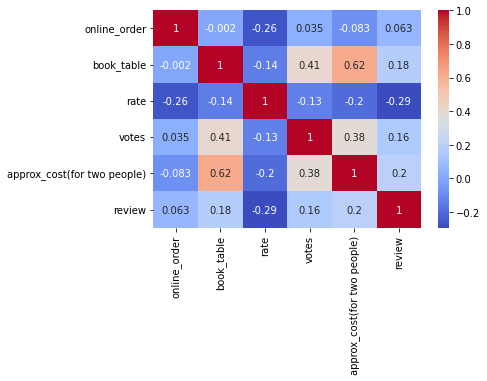

In [18]:
#Correlation
corr_matrix=df.corr()
sns.heatmap(data = corr_matrix,annot=True,cmap=plt.cm.coolwarm)

In [19]:
#Feature Selection
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=3)
model.fit(df[["votes","review","approx_cost(for two people)","online_order","book_table"]],df.rate)
#max_depth represents the depth of each tree in the forest. The deeper the tree
#the more splits it has and it captures more information about the data.

RandomForestRegressor(random_state=3)

feature:0, Score:0.8318141311366418
feature:1, Score:0.10093170378318843
feature:2, Score:0.03922483274495198
feature:3, Score:0.014343301027423592
feature:4, Score:0.013686031307794047


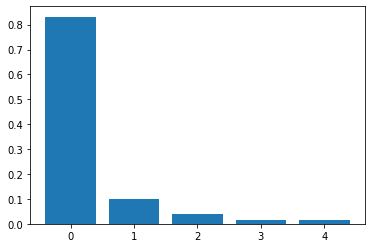

In [20]:
importances = model.feature_importances_
for i,v in enumerate(importances):
    print(f'feature:{i}, Score:{v}')
    # plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='review', ylabel='Density'>

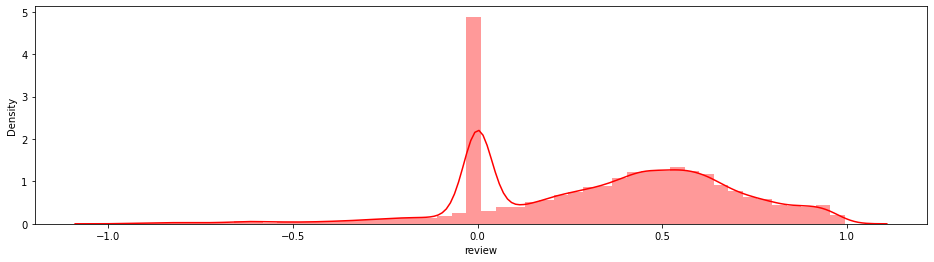

In [21]:
fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(df["review"],ax=ax,color="red")

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rate', ylabel='Density'>

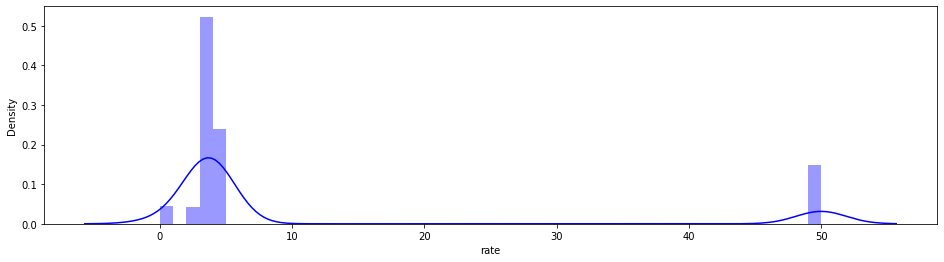

In [22]:
fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(df["rate"],ax=ax,color="blue")

# Outlier Detection and removal

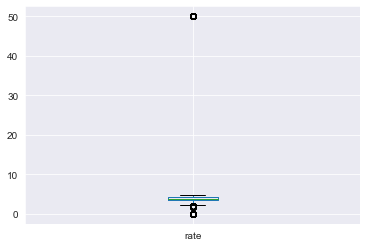

In [23]:
sns.set_style('dark')
df.boxplot(column = ['rate'])
plt.show()

In [24]:
# IQR

In [25]:
Q1 = df['rate'].quantile(.25)
Q3 = df['rate'].quantile(.75)
IQR = Q3 - Q1
uw_rate = Q3 + (1.5 * IQR)
lw_rate = Q1 - (1.5 * IQR)
print(uw_rate)
print(lw_rate)

5.4
2.1999999999999993


In [26]:
#log transformation

In [27]:
import numpy as np
df['log_rate'] = df['rate'].map(lambda i : np.log(i) if i > 0 else 0)
print('skewness before Log T:',df['rate'].skew())
print('skewness after Log T:',df['log_rate'].skew())

skewness before Log T: 1.9611506198597555
skewness after Log T: 1.5453143591733525


In [28]:
#flooring and capping

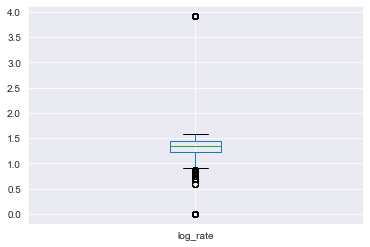

In [29]:
sns.set_style('dark')
df.boxplot(column = ['log_rate'])
plt.show()

In [30]:
Q1 = df['log_rate'].quantile(.25)
Q3 = df['log_rate'].quantile(.75)
IQR = Q3 - Q1
uw_rate_l = Q3 + (1.5 * IQR)
lw_rate_l = Q1 - (1.5 * IQR)
print(uw_rate_l)
print(lw_rate_l)

1.7520481657901334
0.906811791121305


In [31]:
df['log_rate'] = np.where(df['log_rate'] < lw_rate_l , lw_rate_l, df['log_rate'])
df['log_rate'] = np.where(df['log_rate'] > uw_rate_l, uw_rate_l, df['log_rate'])

0.2889744253677813


<AxesSubplot:>

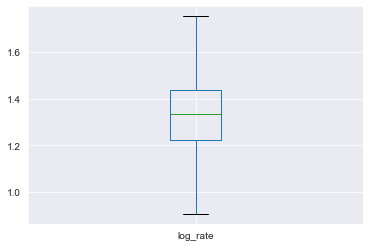

In [32]:
print(df['log_rate'].skew())
df.boxplot(column = ['log_rate'])

In [33]:
df['votes_log'] = df['votes'].map(lambda i : np.log(i) if i > 0 else 0)
print('skewness before Log T:',df['votes'].skew())
print('skewness after Log T:',df['votes_log'].skew())

skewness before Log T: 7.540480691113615
skewness after Log T: -0.07155476811826976


In [34]:
df["review"] = df["review"].map(lambda i : np.log(i) if i > 0 else 0)
print('skewness before Log T:',df["review"].skew())
print('skewness after Log T:',df["review"].skew())

skewness before Log T: -2.244728585432555
skewness after Log T: -2.244728585432555


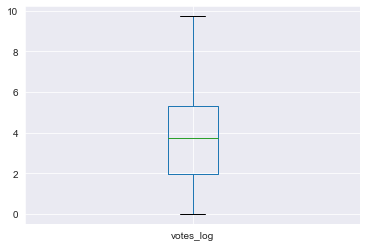

10.31439683822826
-3.0751818644484548
After flooring and Capping


<AxesSubplot:>

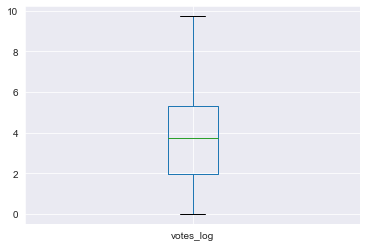

In [35]:
sns.set_style('dark')
df.boxplot(column = ['votes_log'])
plt.show()
Q1 = df['votes_log'].quantile(.25)
Q3 = df['votes_log'].quantile(.75)
IQR = Q3 - Q1
uw_rate_l = Q3 + (1.5 * IQR)
lw_rate_l = Q1 - (1.5 * IQR)
print(uw_rate_l)
print(lw_rate_l)
print("After flooring and Capping")
df['votes_log'] = np.where(df['votes_log'] < lw_rate_l , lw_rate_l, df['votes_log'])
df['votes_log'] = np.where(df['votes_log'] > uw_rate_l, uw_rate_l, df['votes_log'])
df.boxplot(column = ['votes_log'])

In [70]:
df.tail()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,cuisines,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),review,log_rate,votes_log,cluster
51712,https://www.zomato.com/bangalore/best-brews-fo...,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,0,0,3.6,27,080 40301477,Whitefield,Bar,Continental,1500,"[('Rated 5.0', ""RATED\n Food and service are ...",Pubs and bars,Whitefield,-0.518123,1.280934,3.295837,KMeans(n_clusters=3)
51713,https://www.zomato.com/bangalore/vinod-bar-and...,"Number 10, Garudachar Palya, Mahadevapura, Whi...",Vinod Bar And Restaurant,0,0,50.0,0,+91 8197675843,Whitefield,Bar,Finger Food,600,[],Pubs and bars,Whitefield,0.000000,1.752048,0.000000,KMeans(n_clusters=3)
51714,https://www.zomato.com/bangalore/plunge-sherat...,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Plunge - Sheraton Grand Bengaluru Whitefield H...,0,0,50.0,0,0,Whitefield,Bar,Finger Food,2000,[],Pubs and bars,Whitefield,0.000000,1.752048,0.000000,KMeans(n_clusters=3)
51715,https://www.zomato.com/bangalore/chime-sherato...,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,0,1,4.3,236,080 49652769,"ITPL Main Road, Whitefield",Bar,Finger Food,2500,"[('Rated 4.0', 'RATED\n Nice and friendly pla...",Pubs and bars,Whitefield,-0.125280,1.458615,5.463832,KMeans(n_clusters=3)
51716,https://www.zomato.com/bangalore/the-nest-the-...,"ITPL Main Road, KIADB Export Promotion Industr...",The Nest - The Den Bengaluru,0,0,3.4,13,+91 8071117272,"ITPL Main Road, Whitefield","Bar, Casual Dining","Finger Food, North Indian, Continental",1500,"[('Rated 5.0', 'RATED\n Great ambience , look...",Pubs and bars,Whitefield,-0.222894,1.223775,2.564949,KMeans(n_clusters=3)


In [36]:
sign=[]
for i in range(0,10000):
    sign.append(i)  

In [58]:
new=df[:10000]
new["index"]=sign

C:\Users\hp\AppData\Local\Temp\ipykernel_11564\3166320053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["index"]=sign


In [59]:
new1=new.pivot(index="index",columns="name",values=["log_rate","votes_log","review"]).fillna(0)

In [39]:
from scipy.sparse import csr_matrix
from fuzzywuzzy import process

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [60]:
matrix=csr_matrix(new1.values)
matrix

<10000x13980 sparse matrix of type '<class 'numpy.float64'>'
	with 25433 stored elements in Compressed Sparse Row format>

In [61]:
#Model Building
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(metric="cosine",algorithm="brute",n_neighbors=5)
model.fit(matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [62]:
def recommender1(name,data,n):
    idx=process.extractOne(name,new["name"])[2]
    distance, indices=model.kneighbors(data[idx],n_neighbors=n)
    for i in indices:
        print(new["name"][i])
recommender1("Banashankari",matrix,5)

56       Banashankari Donne Biriyani
658                 The Biryani Cafe
2576               Biryanis And More
3584              Thrilok Restaurant
9998    Swa-Desh A Family Restaurant
Name: name, dtype: object
